In [118]:
import numpy as np

from database.models import InstancesN8, InstancesN12, InstancesN16
import data_service
import ast

def base_N_hamming_distance(i: int, j: int, N: int) -> int:
    arr_i = np.array([int(s) for s in bin(i)[2:].zfill(N)])
    arr_j = np.array([int(s) for s in bin(j)[2:].zfill(N)])
    return int(np.sum(arr_i != arr_j))

In [132]:
N = 16



Instance = data_service.get_instance_class(N)


with data_service.get_session() as session:

    instances: list[InstancesN8 | InstancesN12] = (
        session.query(Instance).where(Instance.degeneracy == 8).all()
    )

    hamming_hash_map_dist = {}
    hamming_hash_map_qfi = {}
    hamming_hash_map_od = {}

    for instance in instances:
        gs = instance.reduced_gs
        deg = instance.degeneracy // 2

        hamming_list = []

        for i in range(deg):
            for j in range(i+1, deg):
                hamming_list.append(base_N_hamming_distance(gs[i],gs[j],N))
        

        hashed_hamming_distances = str(sorted(hamming_list, reverse=True))
        if hashed_hamming_distances in hamming_hash_map_dist:
            hamming_hash_map_dist[hashed_hamming_distances].append(instance.dist_fair_sampling)
            hamming_hash_map_qfi[hashed_hamming_distances].append(instance.qfi_fair_sampling)
            hamming_hash_map_od[hashed_hamming_distances].append(instance.od_variance)
        else:
            hamming_hash_map_dist[hashed_hamming_distances] = [instance.dist_fair_sampling]
            hamming_hash_map_qfi[hashed_hamming_distances] = [instance.qfi_fair_sampling]
            hamming_hash_map_od[hashed_hamming_distances] = [instance.od_variance]
        

                

    session.close()

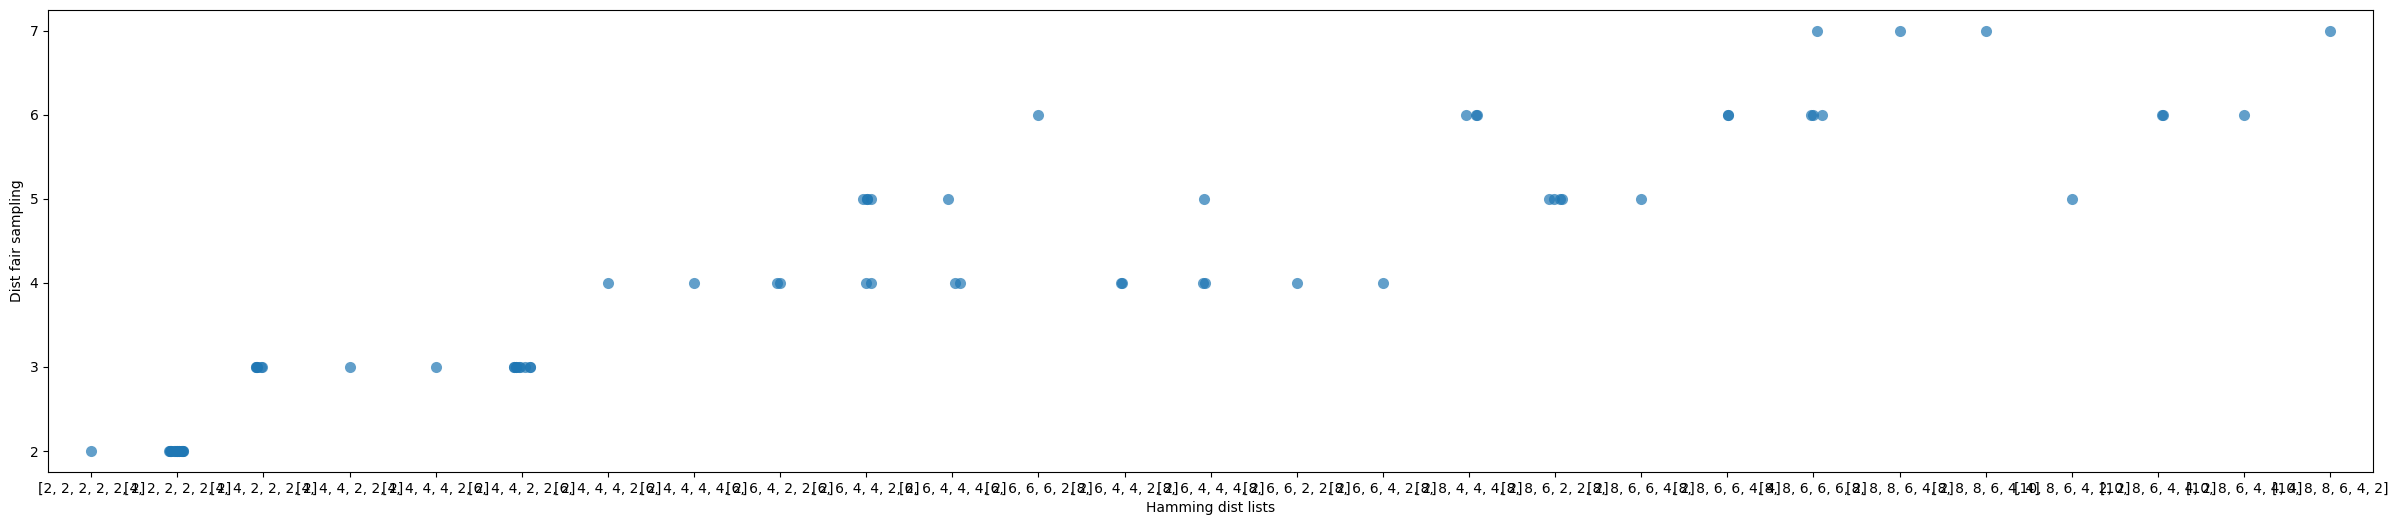

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for plotting
# Convert dictionary to a DataFrame with two columns: 'bucket' and 'value'
df = pd.DataFrame([(hd_list, dist_fs) for hd_list, dist_fs_list in hamming_hash_map_dist.items() for dist_fs in dist_fs_list], columns=['hd_list', 'dist_fs'])

df = df.sort_values(by=['hd_list'], key = lambda col: col.apply(ast.literal_eval))


# Plot
plt.figure(figsize=(30, 6))
sns.stripplot(x='hd_list', y='dist_fs', data=df, jitter=True, size=8, alpha=0.7)  # jitter helps to separate points

# Add labels
plt.xlabel('Hamming dist lists')
plt.ylabel('Dist fair sampling')

plt.show()


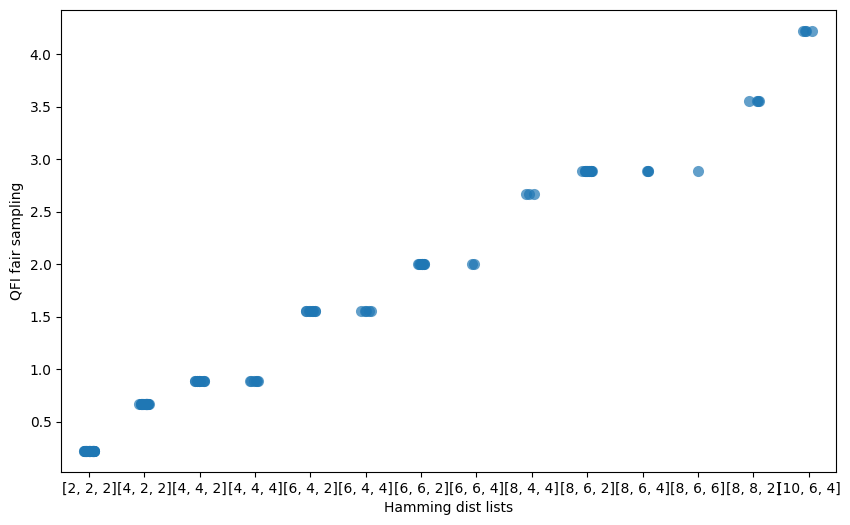

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for plotting
# Convert dictionary to a DataFrame with two columns: 'bucket' and 'value'
df = pd.DataFrame([(hd_list, qfi_fs) for hd_list, qfi_fs_list in hamming_hash_map_qfi.items() for qfi_fs in qfi_fs_list], columns=['hd_list', 'qfi_fs'])

df = df.sort_values(by=['hd_list'], key = lambda col: col.apply(ast.literal_eval))


# Plot
plt.figure(figsize=(10, 6))
sns.stripplot(x='hd_list', y='qfi_fs', data=df, jitter=True, size=8, alpha=0.7)  # jitter helps to separate points

# Add labels
plt.xlabel('Hamming dist lists')
plt.ylabel('QFI fair sampling')

plt.show()


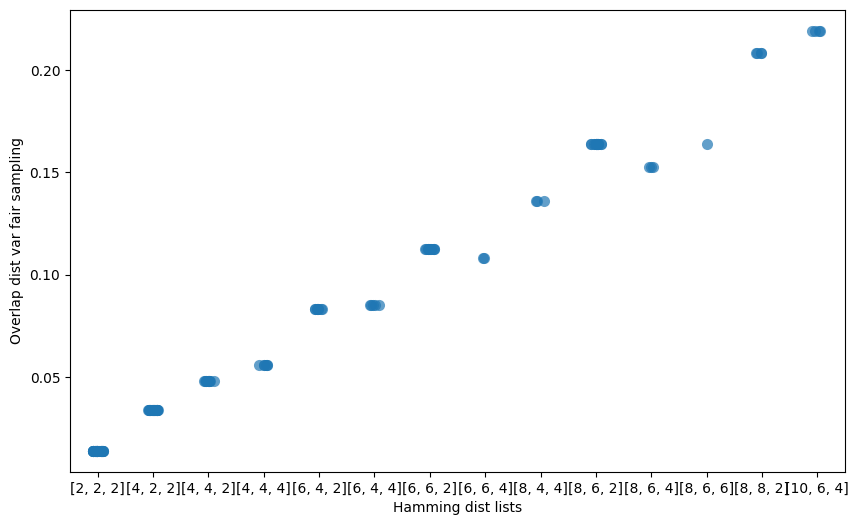

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for plotting
# Convert dictionary to a DataFrame with two columns: 'bucket' and 'value'
df = pd.DataFrame([(hd_list, od_var) for hd_list, od_var_list in hamming_hash_map_od.items() for od_var in od_var_list], columns=['hd_list', 'od_var'])

df = df.sort_values(by=['hd_list'], key = lambda col: col.apply(ast.literal_eval))


# Plot
plt.figure(figsize=(10, 6))
sns.stripplot(x='hd_list', y='od_var', data=df, jitter=True, size=8, alpha=0.7)  # jitter helps to separate points

# Add labels
plt.xlabel('Hamming dist lists')
plt.ylabel('Overlap dist var fair sampling')

plt.show()

In [116]:
N = 16



Instance = data_service.get_instance_class(N)


with data_service.get_session() as session:

    instances: list[InstancesN8 | InstancesN12] = (
        session.query(Instance).where(Instance.degeneracy == 6).all()
    )


    hd_df  = pd.DataFrame(columns=['seed','hamming_hash', 'dist_fs'])
    seed_to_hamming_hash = {}

    for k, instance in enumerate(instances):
        gs = instance.reduced_gs
        deg = instance.degeneracy // 2

        hamming_list = []

        for i in range(deg):
            for j in range(i+1, deg):
                hamming_list.append(base_N_hamming_distance(gs[i],gs[j],N))
        
        hd_df.loc[k] = [instance.seed, str(sorted(hamming_list, reverse=True)), instance.dist_fair_sampling]

        

In [117]:
hd_df[hd_df['hamming_hash'] == '[6, 4, 2]']

,seed,hamming_hash,dist_fs
5,93,"[6, 4, 2]",4.000000
18,225,"[6, 4, 2]",4.000000
34,539,"[6, 4, 2]",4.000000
66,975,"[6, 4, 2]",5.333333
81,1222,"[6, 4, 2]",4.000000
94,1376,"[6, 4, 2]",5.333333
104,1568,"[6, 4, 2]",5.333333
123,1870,"[6, 4, 2]",4.000000


In [109]:
import itertools as it

gs_indeces = [18,210,212, 256, 257]
deg = len(gs_indeces)

splittings = []


for A in it.combinations(gs_indeces,deg//2):
    D = tuple(gs for gs in gs_indeces if gs not in A)
    splittings.append((A,D))

splittings

[((18, 210), (212, 256, 257)),
 ((18, 212), (210, 256, 257)),
 ((18, 256), (210, 212, 257)),
 ((18, 257), (210, 212, 256)),
 ((210, 212), (18, 256, 257)),
 ((210, 256), (18, 212, 257)),
 ((210, 257), (18, 212, 256)),
 ((212, 256), (18, 210, 257)),
 ((212, 257), (18, 210, 256)),
 ((256, 257), (18, 210, 212))]

In [124]:
N = 16

Instance = data_service.get_instance_class(N)


with data_service.get_session() as session:

    instances : List[Union[InstancesN8, InstancesN12, InstancesN16]] = (
        session.query(Instance)
        .where(Instance.seed.in_([93,975]))
        .all()
    )

    for instance in instances:

        gs = instance.reduced_gs
        deg = instance.degeneracy // 2
        pa_gs_probs = np.array(instance.post_anneal_gs_probs)

        hamming_matrix = np.zeros((deg, deg))

        for i in range(deg):
            for j in range(i + 1, deg):
                hamming_matrix[i][j] = hamming_matrix[j][i] = (
                    base_N_hamming_distance(gs[i], gs[j], N)
                )

        gs_indeces = [i for i in range(deg)]
        splittings = []
        for D in it.combinations(gs_indeces, deg // 2):
            A = tuple(gs_i for gs_i in gs_indeces if gs_i not in D)
            splittings.append((D, A))

        dist_list_fair = np.zeros(len(splittings))
        dist_list_pa = np.zeros(len(splittings))

        print("---------------------:", instance.seed)

        for i in range(len(splittings)):
            D = list(splittings[i][0])
            A = list(splittings[i][1])

            # if np.sum(pa_gs_probs[A]) < np.sum(pa_gs_probs[D]):
            #     A, D = D, A

            print("A", A)
            print("D", D)

            d_list_fair = np.zeros(len(D))
            d_list_pa = np.zeros(len(D))
            for j, gs_j in enumerate(D):
                d_list_fair[j] = np.min(hamming_matrix[gs_j, A]) * (1 / deg)
                d_list_pa[j] = np.min(hamming_matrix[gs_j, A]) * pa_gs_probs[gs_j]
            dist_list_fair[i] = 2 * np.sum(d_list_fair)
            dist_list_pa[i] = 2 * np.sum(d_list_pa)

            print("dlist_fair", d_list_fair)

        print(dist_list_fair)

    session.commit()
    session.close()


---------------------: 93
A [1, 2]
D [0]
dlist_fair [0.66666667]
A [0, 2]
D [1]
dlist_fair [0.66666667]
A [0, 1]
D [2]
dlist_fair [1.33333333]
[1.33333333 1.33333333 2.66666667]
---------------------: 975
A [1, 2]
D [0]
dlist_fair [1.33333333]
A [0, 2]
D [1]
dlist_fair [0.66666667]
A [0, 1]
D [2]
dlist_fair [0.66666667]
[2.66666667 1.33333333 1.33333333]
